For this project we will 
    - implement SGD
    - implement varrying 
    - implement batch SGD
    - other variations of accelerations

In [1]:
import numpy as np

In [31]:
def SGD(A, b, steps, a):
    m, n = A.shape

    x = np.zeros(n)

    xstar, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

    errors = np.zeros(steps + 1)

    errors[0] = np.linalg.norm(x - xstar) / np.linalg.norm(xstar)

    for j in range(steps):
        i = np.random.randint(0, m)

        residual = (A[i] @ x - b[i])
        gradient = 2 * residual * A[i]

        x = x - a * gradient

        errors[j+1] = np.linalg.norm(x - xstar) / np.linalg.norm(xstar)

    return x, errors

In [26]:
np.random.seed(42)
rows, cols = 100, 10
A = np.random.randn(rows, cols)
x_true = np.random.randn(cols)
# Create b with some noise so the error doesn't go to absolute zero
b = A @ x_true + 0.1 * np.random.randn(rows)
step_size = 0.01

In [27]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Error')

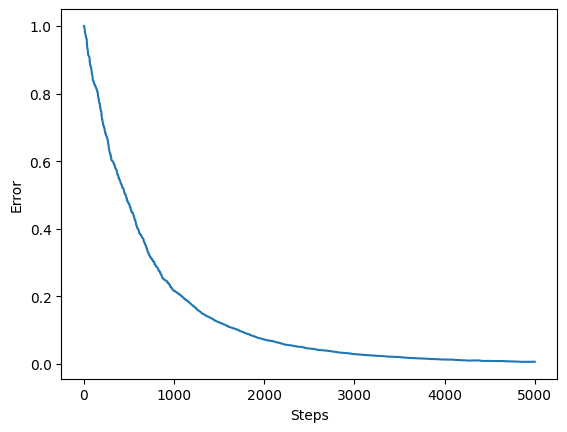

In [ ]:
steps = 5000
learning_rate = 0.001

error_history = SGD(A, b, steps, learning_rate)[1]
plt.plot(error_history)
plt.xlabel('Steps')
plt.ylabel('Error')

In [ ]:
def SGD_Momentum(A, b, steps, a, beta=0.9):
    m, n = A.shape
    x = np.zeros(n)

    # Initialize velocity vector (same shape as x)
    velocity = np.zeros(n)

    xstar, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

    errors = np.zeros(steps + 1)
    errors[0] = np.linalg.norm(x - xstar) / np.linalg.norm(xstar)

    for j in range(steps):
        i = np.random.randint(0, m)

        residual = (A[i] @ x - b[i])
        gradient = 2 * residual * A[i]
        velocity = beta * velocity + a * gradient
        x = x - velocity

        errors[j+1] = np.linalg.norm(x - xstar) / np.linalg.norm(xstar)

    return x, errors

Text(0, 0.5, 'Error')

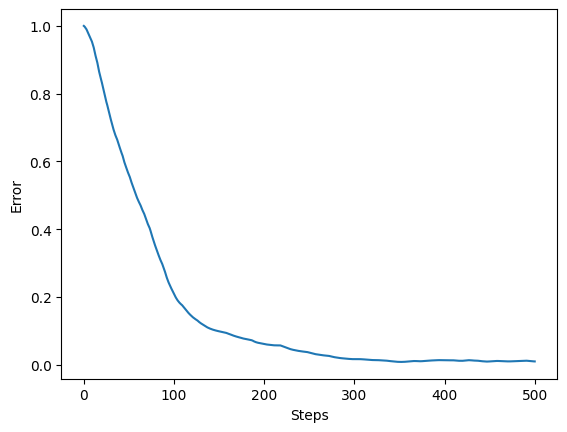

In [45]:
steps = 500
learning_rate = 0.001

error_history_momentum = SGD_Momentum(A, b, steps, learning_rate)[1]
plt.plot(error_history_momentum)
plt.xlabel('Steps')
plt.ylabel('Error')

Text(0, 0.5, 'Error')

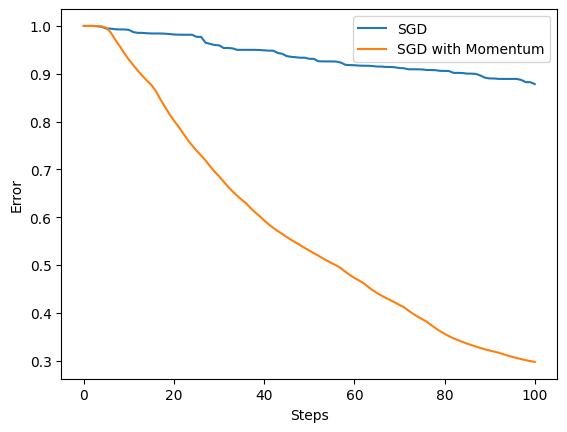

In [44]:
steps = 100
error_history = SGD(A, b, steps, learning_rate)[1]
error_history_momentum = SGD_Momentum(A, b, steps, learning_rate)[1]
plt.plot(error_history)
plt.plot(error_history_momentum)
plt.legend(['SGD', 'SGD with Momentum'])
plt.xlabel('Steps')
plt.ylabel('Error')

In [ ]:
def SGD_Vary_Step(A, b, steps, a_initial, decay_rate=1.1):
    m, n = A.shape
    x = np.zeros(n)
    xstar, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

    errors = np.zeros(steps + 1)
    errors[0] = np.linalg.norm(x - xstar) / np.linalg.norm(xstar)

    for j in range(steps):
        i = np.random.randint(0, m)

        residual = (A[i] @ x - b[i])
        gradient = 2 * residual * A[i]

        # --- UPDATE STEP SIZE ---
        # Calculate the dynamic step size for this iteration
        # As j increases, current_a decreases.
        current_a = a_initial / decay_rate

        # Update x using the new current_a
        x = x - current_a * gradient
        # ------------------------

        errors[j+1] = np.linalg.norm(x - xstar) / np.linalg.norm(xstar)

    return x, errors

Text(0, 0.5, 'Error')

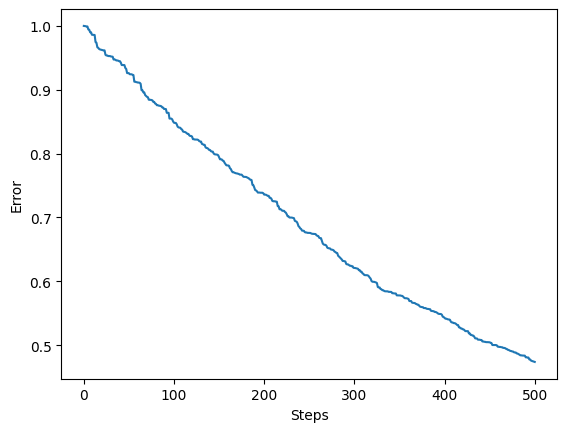

In [56]:
steps = 500
learning_rate = 0.001

error_history_vary = SGD_Vary_Step(A,b,steps,learning_rate)[1]
plt.plot(error_history_vary)
plt.xlabel('Steps')
plt.ylabel('Error')

Text(0, 0.5, 'Error')

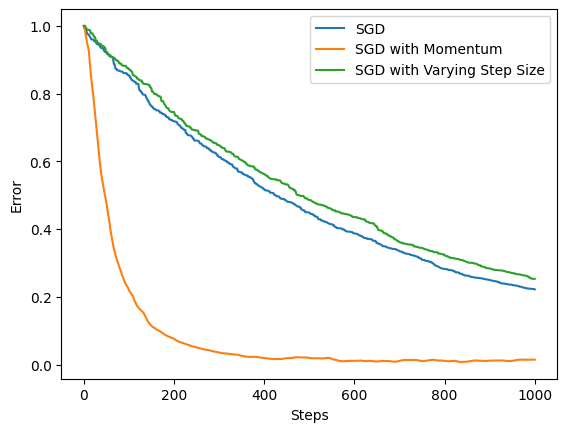

In [59]:
steps = 1000
error_history = SGD(A, b, steps, learning_rate)[1]
error_history_momentum = SGD_Momentum(A, b, steps, learning_rate)[1]
error_history_vary = SGD_Vary_Step(A,b,steps,learning_rate)[1]
plt.plot(error_history)
plt.plot(error_history_momentum)
plt.plot(error_history_vary)
plt.legend(['SGD', 'SGD with Momentum', 'SGD with Varying Step Size'])
plt.xlabel('Steps')
plt.ylabel('Error')